In [31]:
#importing required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import random
import numpy as np
from model import Net # importing the best model created 

In [2]:
# setting up constants
EPOCHS = 20
BATCH_SIZE = 64

In [3]:
# using gpu if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
# setting the transforms and normalizing the images
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomRotation((-7.0, 7.0)),
                        transforms.RandomAffine(0, (0.05, 0.05))
])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# creating train and test dataset
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [6]:
SEED = 22

cuda = torch.cuda.is_available()
print(cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0004)
 - std: tensor(0.1133)
 - var: tensor(0.0128)
torch.Size([128, 1, 28, 28])
torch.Size([128])


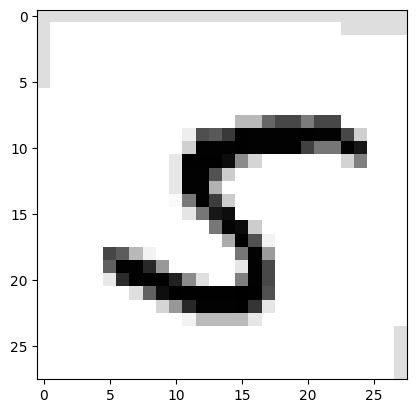

In [7]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

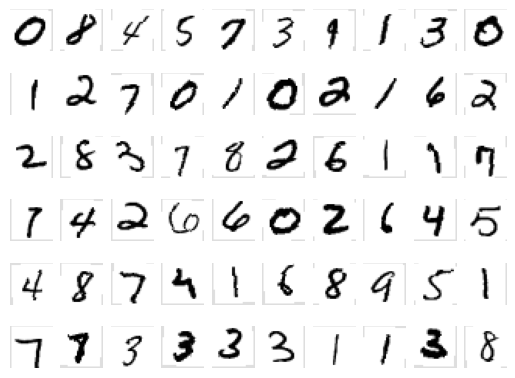

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, l1_loss = False, lambda_l1= 0.01):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # if L1 regularization
    if l1_loss == True:
        l1 = 0
        for p in model.parameters():
            l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1 * l1
    
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

misclassified = []

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            if epoch == EPOCHS-1:
                idxs_mask = ((pred == target.view_as(pred)) == False).view(-1)
                if idxs_mask.sum() == 1:
                    misclassified.append([data[idxs_mask].squeeze().unsqueeze(0).cpu().numpy(), target[idxs_mask].cpu().numpy(), pred[idxs_mask].squeeze().unsqueeze(0).cpu().numpy()])
                elif idxs_mask.sum() > 1:
                    misclassified.append([data[idxs_mask].squeeze().cpu().numpy(), target[idxs_mask].cpu().numpy(), pred[idxs_mask].squeeze().cpu().numpy()])
                    
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#### Plotting funtions for test loss and test accuracy for the below models

In [10]:
def plot_loss(ln_loss, gn_loss, bn_loss):
    epochs = [i for i in range(EPOCHS)]
    plt.plot(x=epochs, y=ln_loss, label="Layer Norm")
    plt.plot(x=epochs, y=gn_loss, label="Group Norm")
    plt.plot(x=epochs, y=bn_loss, label="Batch Norm + L1")
    plt.xlabel('EPOCHS')
    plt.ylabel('Loss')
    plt.grid()
    plt.title("Losses for all 3 models")
    plt.legend()
    plt.show()

def plot_acc(ln_acc, gn_acc, bn_acc):
    epochs = [i for i in range(EPOCHS)]
    plt.plot(x=epochs, y=ln_acc, label="Layer Norm")
    plt.plot(x=epochs, y=gn_acc, label="Group Norm")
    plt.plot(x=epochs, y=bn_acc, label="Batch Norm + L1")
    plt.xlabel('EPOCHS')
    plt.ylabel('Accuracy')
    plt.title("Accuracy for all 3 models")
    plt.grid()
    plt.legend()
    plt.show()

#### Plotting misclassified images

In [45]:
def plot_misclassified(misclassified):
    temp_image = misclassified[0][0]
    temp_label = misclassified[0][1]
    temp_pred = misclassified[0][2]
    for i in range(1, len(misclassified)):
        temp_image = np.concatenate((temp_image, misclassified[i][0]), axis=0)
        temp_label = np.concatenate((temp_label, misclassified[i][1]), axis=0)
        temp_pred = np.concatenate((temp_pred, misclassified[i][2]), axis=0)
    miss = [temp_image, temp_label, temp_pred]

    fig, axs = plt.subplots(5, 2)
    for i, index in zip(range(1, 11), [random.randint(0, len(misclassified)) for _ in range(10)]):
        plt.subplot(5, 2, i)
        plt.axis("off")
        plt.imshow(miss[0][index], cmap='gray_r')

## Layer Normalization

In [12]:
model_ = Net(norm='ln').to(device)
summary(model_, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         GroupNorm-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
         GroupNorm-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
        GroupNorm-12            [-1, 8, 10, 10]              16
             ReLU-13            [-1, 8, 10, 10]               0
          Dropout-14            [-1, 8,

In [13]:
model =  Net(norm='ln').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader, epoch)

EPOCH: 0


Loss=0.14625626802444458 Batch_id=468 Accuracy=78.13: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.1846, Accuracy: 9417/10000 (94.17%)

EPOCH: 1


Loss=0.07368447631597519 Batch_id=468 Accuracy=95.07: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s] 



Test set: Average loss: 0.0725, Accuracy: 9769/10000 (97.69%)

EPOCH: 2


Loss=0.03214339539408684 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s] 



Test set: Average loss: 0.0510, Accuracy: 9841/10000 (98.41%)

EPOCH: 3


Loss=0.04959198832511902 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s] 



Test set: Average loss: 0.0547, Accuracy: 9822/10000 (98.22%)

EPOCH: 4


Loss=0.03154716268181801 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s] 



Test set: Average loss: 0.0328, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.13423769176006317 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s] 



Test set: Average loss: 0.0323, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.04612467810511589 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]  



Test set: Average loss: 0.0319, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Loss=0.17444737255573273 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s] 



Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.006576680112630129 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0289, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.005355096887797117 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s] 



Test set: Average loss: 0.0292, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.01861855946481228 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]  



Test set: Average loss: 0.0293, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.03414562717080116 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 28.15it/s] 



Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.05211656913161278 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]  



Test set: Average loss: 0.0290, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.045865919440984726 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s] 



Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.06815362721681595 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]  



Test set: Average loss: 0.0289, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Loss=0.018230214715003967 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s] 



Test set: Average loss: 0.0288, Accuracy: 9911/10000 (99.11%)

EPOCH: 16


Loss=0.008319291286170483 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]



Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.04133925214409828 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]  



Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 18


Loss=0.014592139981687069 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]



Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 19


Loss=0.024471275508403778 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s] 



Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)



In [14]:
ln_loss = test_losses
ln_acc = test_acc

C:\Users\3dsma\AppData\Local\Temp\ipykernel_4860\967574200.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 2, i, label=f"Ground Truth: {miss[0][index]} \n Predicted: {miss[0][index]}")


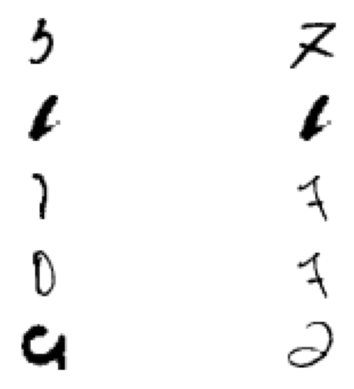

In [46]:
plot_misclassified(misclassified)
# misclassified[39][0].shape
# tuple(zip(range(1, 11), [random.randint(0, len(misclassified)) for _ in range(10)]))

## Group Normalization

In [ ]:
model_ = Net(norm='gn').to(device)
summary(model_, input_size=(1, 28, 28))

In [ ]:
model =  Net(norm='gn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_losses.clear()
test_losses.clear()
train_acc.clear()
test_acc.clear()

misclassified.clear()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

In [ ]:
gn_loss = test_losses
gn_acc = test_acc

## Batch Normalization + L1

In [ ]:
model_ = Net(norm='bn').to(device)
summary(model_, input_size=(1, 28, 28))

In [ ]:
model =  Net(norm='bn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_losses.clear()
test_losses.clear()
train_acc.clear()
test_acc.clear()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, l1_loss=True)
    scheduler.step()
    test(model, device, test_loader)

In [ ]:
bn_loss = test_losses
bn_acc = test_acc